# Face Emotion Detection

### Advanced machine learning lab

### Imports

In [49]:
# ML
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

# Data
import pandas as pd
from sklearn.utils import shuffle

# Linalg
import numpy as np

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

### Global variables

In [50]:
IMG_SIZE = 48
BATCH_SIZE = 64
CLASSES = ['neutral', 'happy', 'surprised', 'sad', 'angry', 'disgusted', 'afraid']
NUM_CLASSES = len(CLASSES)

In [51]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('running on:', device)

running on: cuda:0


### Data loading

In [52]:
# Load the data and place them in 'images' and 'labels' arrays
images = pd.read_csv('data/fer2013.csv').iloc[:,2].to_list()
images = np.array([list(map(int, i.split())) for i in images], dtype=np.uint8)
images = np.reshape(images, (-1, 48, 48))

labels = np.array(pd.read_csv('data/fer2013.csv').iloc[:,0].to_list())

In [53]:
# Shuffle the data
images, labels = shuffle(images, labels, random_state=0)

In [54]:
# Split the data in train and test sets
train_prcnt = 0.8
train_len = int(train_prcnt * len(images))

train_images = images[:train_len]
train_labels = labels[:train_len]

test_images = images[train_len:]
test_labels = labels[train_len:]

In [55]:
# Custom dataset for images and labels
class CustomDataset(Dataset):
    
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [56]:
# Create the datasets and the dataloaders

# Data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMG_SIZE),
    #torchvision.transforms.RandomHorizontalFlip(),
    #torchvision.transforms.RandomRotation(20)
])

train_dataset = CustomDataset(train_images, train_labels, transform)
test_dataset = CustomDataset(test_images, test_labels, transform)
train_loader = DataLoader(train_dataset)
test_loader = DataLoader(test_dataset)

### Display the data

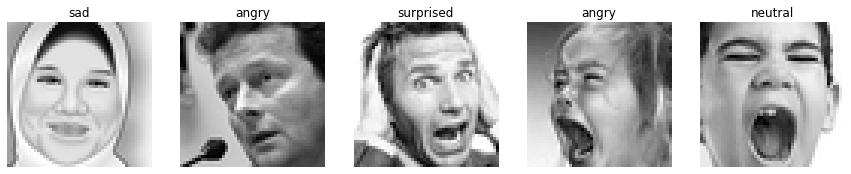

In [57]:
plt.figure(figsize=(15, 5))
i = 0
for image, label in train_loader:
    if i == 5:
        break
    plt.subplot(1, 5, i+1)
    plt.axis("off")
    plt.imshow(image[0][0], cmap="gray")
    plt.title(CLASSES[label])
    i += 1

### The model

In [58]:
class CNN(nn.Module):
    def __init__(self, n_features):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_features, kernel_size=5)
        self.conv2 = nn.Conv2d(n_features, n_features, kernel_size=5)

        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(n_features*9*9, 1024)
        self.fc2 = nn.Linear(1024, NUM_CLASSES)   
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [59]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(out_channels), nn.ELU(inplace=True)]
  if pool: 
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = conv_block(1, 128)
    self.conv2 = conv_block(128, 128, pool=True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
    self.drop1 = nn.Dropout(0.5)
    
    self.conv3 = conv_block(128, 256)
    self.conv4 = conv_block(256, 256, pool=True)
    self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
    self.drop2 = nn.Dropout(0.5)
    
    self.conv5 = conv_block(256, 512)
    self.conv6 = conv_block(512, 512, pool=True)
    self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
    self.drop3 = nn.Dropout(0.5)
    
    self.classifier = nn.Sequential(nn.MaxPool2d(6), nn.Flatten(), nn.Linear(512, NUM_CLASSES))


  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.drop1(out)

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.drop2(out)

    out = self.conv5(out)
    out = self.conv6(out)
    out = self.res3(out) + out
    out = self.drop3(out)

    out = self.classifier(out)
    return out

### Train and test functions

In [60]:
def train(model, data, criterion, optimizer):
    model.train()
    loss = 0
    corrects = 0

    for X, y in data:
        y = y.type(torch.LongTensor)   # casting to long
        X, y = X.to(device), y.to(device)

        Y = model(X)
        loss = criterion(Y, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss += loss.item()
        corrects += (Y.argmax(1) == y).type(torch.float).sum().item()

    epoch_loss = loss / len(train_dataset)
    epoch_accuracy = corrects / len(train_dataset)
    print(f"  TRAIN\t loss: {epoch_loss:.4f}  |  accuracy: {epoch_accuracy:.4f}")
        

In [61]:
def test(model, data, criterion):
    model.eval()
    loss = 0.0
    corrects = 0
    
    for X, y in data:
        y = y.type(torch.LongTensor)   # casting to long
        X, y = X.to(device), y.to(device)

        with torch.no_grad():
            pred = model(X)
        
        loss = criterion(pred, y)
        loss += loss.item()
        corrects += (pred.argmax(1) == y).type(torch.float).sum().item()

    epoch_loss = loss / len(test_dataset)
    epoch_accuracy = corrects / len(test_dataset)
    print(f"  TEST\t loss: {epoch_loss:.4f}  |  accuracy: {epoch_accuracy:.4f}")

In [64]:
model = ResNet()
model.to(device)

EPOCHS = 10
LEARNING_RATE = 0.005
MOMENTUM = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [65]:
for epoch in range(EPOCHS):
    print('Epoch {}/{}'.format(epoch+1, EPOCHS))
    train(model, test_loader, criterion, optimizer)
    test(model, test_loader, criterion)
    scheduler.step()

Epoch 1/10
  TRAIN	 loss: 0.0003  |  accuracy: 0.0580
  TEST	 loss: 0.0018  |  accuracy: 0.1524
Epoch 2/10


KeyboardInterrupt: 